# Project Notebook

### Imports

In [363]:
import numpy as np
from tensorflow import keras
import tensorflow as tf
from keras.layers import Conv2D, Conv2DTranspose, LeakyReLU, Add, Input
from keras.models import Model
from tensorflow.nn import depth_to_space
from matplotlib import pyplot as plt
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing import image_dataset_from_directory
from PIL import Image
import math
from scipy.signal import convolve2d

In [364]:
from utils import downsample, normalize, processInput, predict, test_srcnn, psnr
from SRCNN import get_model
import DIPCI

### Data Processing

In [365]:
PATH_DATA = "./Data"

In [366]:
data_ssh = PATH_DATA+"/1308_square_NATL60_SSH_R09.npy"
data_sst = PATH_DATA+"/1308_square_NATL60_SST_R09.npy"
ssh = np.load(data_ssh)
sst = np.load(data_sst)
SSHMIN = ssh.min()
SSHMAX = ssh.max()

In [367]:
def normalize(image, min, max):
    factor = (max - min) / (np.amax(image) - np.amin(image))
    result = (image - np.amin(image)) * factor + min
    return result

In [368]:
ssh_norm = np.array([normalize(img,0,1) for img in ssh])
sst_norm = np.array([normalize(img,0,1) for img in sst])

In [369]:
def downsample(image, factor):
    kernel = np.ones((factor, factor))
    convolved = convolve2d(image, kernel, mode='valid')
    return convolved[::factor, ::factor] / factor 

In [370]:
upscale_factor = 2

In [371]:
ssh_lr = np.array([downsample(img, upscale_factor) for img in ssh_norm])

### SRCNN + SubPixel

In [197]:
early_stopping_callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10)

checkpoint_filepath = "./tmp/checkpoint"

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="loss",
    mode="min",
    save_best_only=True,
)

callbacks = [early_stopping_callback, model_checkpoint_callback]
srcnn = get_model(upscale_factor=upscale_factor, channels=1)
srcnn.summary()
loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=0.001)

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 conv2d_24 (Conv2D)          (None, None, None, 64)    1664      
                                                                 
 conv2d_25 (Conv2D)          (None, None, None, 64)    36928     
                                                                 
 conv2d_26 (Conv2D)          (None, None, None, 32)    18464     
                                                                 
 conv2d_27 (Conv2D)          (None, None, None, 4)     1156      
                                                                 
 tf.nn.depth_to_space_6 (TFO  (None, None, None, 1)    0         
 pLambda)                                                        
                                                           

In [198]:
epochs = 100
srcnn.compile(
    optimizer=optimizer, loss=loss_fn, metrics=['mse', psnr]
)

Training (to skip)

In [199]:
batch_size = 8

In [200]:
train_ds = tf.data.Dataset.from_tensor_slices((ssh_lr[0:366], ssh_norm[0:366]))
train_ds = train_ds.batch(batch_size)

history = srcnn.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=(ssh_lr[366:],ssh_norm[366:]), verbose=1
)

srcnn.save('tmp/model/srcnn')

Epoch 1/100
46/46 [==============================] - 19s 393ms/step - loss: 0.1946 - mse: 0.1946 - psnr: 17.1314 - val_loss: 0.0020 - val_mse: 0.0020 - val_psnr: 27.1018
Epoch 2/100
46/46 [==============================] - 17s 374ms/step - loss: 9.5332e-04 - mse: 9.5332e-04 - psnr: 30.7009 - val_loss: 5.4163e-04 - val_mse: 5.4163e-04 - val_psnr: 32.6785
Epoch 3/100
46/46 [==============================] - 16s 342ms/step - loss: 3.1490e-04 - mse: 3.1490e-04 - psnr: 35.1711 - val_loss: 2.5022e-04 - val_mse: 2.5022e-04 - val_psnr: 36.0401
Epoch 4/100
46/46 [==============================] - 17s 361ms/step - loss: 3.0586e-04 - mse: 3.0586e-04 - psnr: 35.5790 - val_loss: 2.6621e-04 - val_mse: 2.6621e-04 - val_psnr: 35.7767
Epoch 5/100
46/46 [==============================] - 16s 346ms/step - loss: 1.5979e-04 - mse: 1.5979e-04 - psnr: 38.0701 - val_loss: 1.2136e-04 - val_mse: 1.2136e-04 - val_psnr: 39.1887
Epoch 6/100
46/46 [==============================] - 17s 365ms/step - loss: 1.9018e-04

46/46 [==============================] - 16s 357ms/step - loss: 1.2311e-04 - mse: 1.2311e-04 - psnr: 42.3357 - val_loss: 4.7039e-05 - val_mse: 4.7039e-05 - val_psnr: 43.3225
Epoch 46/100
46/46 [==============================] - 16s 354ms/step - loss: 2.6181e-04 - mse: 2.6181e-04 - psnr: 38.8361 - val_loss: 4.0887e-05 - val_mse: 4.0887e-05 - val_psnr: 43.9536
Epoch 47/100
46/46 [==============================] - 16s 359ms/step - loss: 5.3638e-05 - mse: 5.3638e-05 - psnr: 43.4270 - val_loss: 2.5045e-05 - val_mse: 2.5045e-05 - val_psnr: 46.1183
Epoch 48/100
46/46 [==============================] - 17s 377ms/step - loss: 3.6733e-05 - mse: 3.6733e-05 - psnr: 44.8448 - val_loss: 2.9672e-05 - val_mse: 2.9672e-05 - val_psnr: 45.3518
Epoch 49/100
46/46 [==============================] - 16s 351ms/step - loss: 6.6787e-04 - mse: 6.6787e-04 - psnr: 37.4134 - val_loss: 6.5048e-04 - val_mse: 6.5048e-04 - val_psnr: 31.8741
Epoch 50/100
46/46 [==============================] - 17s 370ms/step - loss: 1

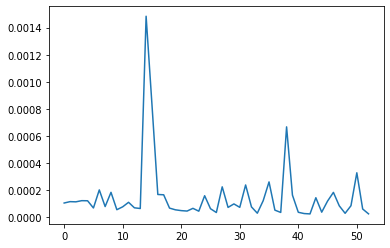

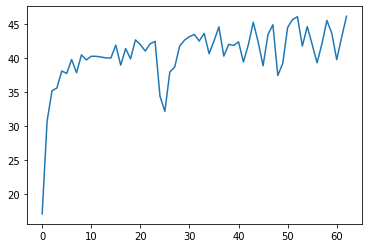

In [204]:
plt.plot(history.history['mse'][10:])
plt.figure()
plt.plot(history.history['psnr'])

Results

In [205]:
def mse(y_pred, y_true):
    return np.square(np.subtract(y_true,y_pred)).mean() 

def rmse(y_pred, y_true):
    return math.sqrt(mse(y_pred, y_true))

def psnr(y_pred, y_true):
    rMSE = rmse(y_pred, y_true)
    if(rMSE == 0):  
        return 100
    return 20 * math.log10(SSHMAX / rMSE)
    
def bicubic_interpolation(array, img_size):
    img = Image.fromarray(array)
    img = img.resize([img_size, img_size])
    return np.asarray(img)

def test_srcnn(model, lr_data, data):
    bicubic_predictions = np.array( [bicubic_interpolation(img, data[0].shape[0]) for img in lr_data] )
    srcnn_predictions = np.array( [model.predict(np.expand_dims(img, axis=0)) for img in lr_data] )
    # denormalize data
    bicubic_predictions = np.array( [ normalize(bicubic_predictions[i], data[i].min() , data[i].max()) for i in range(bicubic_predictions.shape[0]) ] )
    srcnn_predictions = np.array( [ normalize(srcnn_predictions[i].reshape((data[0].shape[0], data[0].shape[1])), data[i].min() , data[i].max()) for i in range(srcnn_predictions.shape[0]) ] )
    # metrics 
    bicubic_psnr = np.array([ psnr(bicubic_predictions[i], data[i]) for i in range(bicubic_predictions.shape[0]) ])
    bicubic_rmse = np.array([ rmse(bicubic_predictions[i], data[i]) for i in range(bicubic_predictions.shape[0]) ])
    srcnn_psnr = np.array([ psnr(srcnn_predictions[i], data[i]) for i in range(srcnn_predictions.shape[0]) ])
    srcnn_rmse = np.array([ rmse(srcnn_predictions[i], data[i]) for i in range(srcnn_predictions.shape[0]) ])
    
    # plot results
    print('Average bicubic PSNR : ', bicubic_psnr.mean())
    print('Average bicubic RMSE : ', bicubic_rmse.mean())
    print('Average SRCNN PSNR : ', srcnn_psnr.mean())
    print('Average SRCNN RMSE : ',srcnn_rmse.mean())
    
    for i in range(0,100,20):
        plt.figure()
        f, (ax2, ax3, ax4) = plt.subplots(1, 3, sharey=True, figsize=(10,5))
        ax2.imshow(bicubic_predictions[i])
        ax2.set_title('bicubic')
        ax3.imshow(srcnn_predictions[i])
        ax3.set_title('SRCNN')
        ax4.imshow(data[i])
        ax4.set_title('Ground Truth')
        plt.show()
        print("PSNR of Bicubic and Ground Truth image is ", bicubic_psnr[i])
        print("PSNR of SRCNN and Ground Truth is ", srcnn_psnr[i])

In [ ]:
srcnn.load_weights(checkpoint_filepath)

Average bicubic PSNR :  45.680033146286235
Average bicubic RMSE :  0.007395597532916707
Average SRCNN PSNR :  43.340631000225116
Average SRCNN RMSE :  0.009811750681316908


<Figure size 432x288 with 0 Axes>

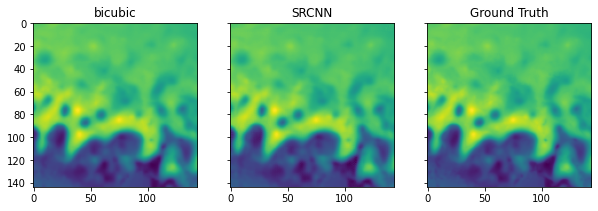

PSNR of Bicubic and Ground Truth image is  46.46335626134429
PSNR of SRCNN and Ground Truth is  43.59822366028473


<Figure size 432x288 with 0 Axes>

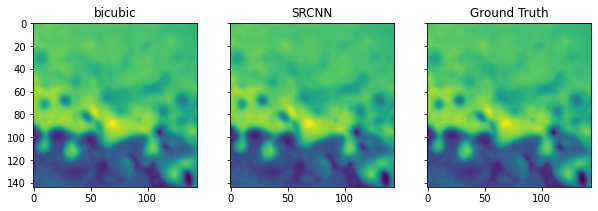

PSNR of Bicubic and Ground Truth image is  44.786809748987004
PSNR of SRCNN and Ground Truth is  45.14002692989741


<Figure size 432x288 with 0 Axes>

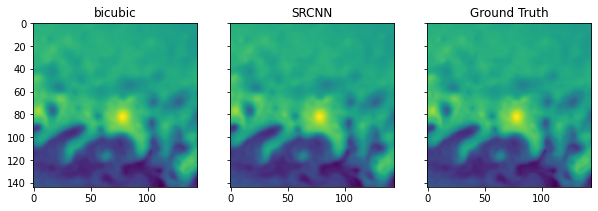

PSNR of Bicubic and Ground Truth image is  47.412441423047426
PSNR of SRCNN and Ground Truth is  45.217315595973766


<Figure size 432x288 with 0 Axes>

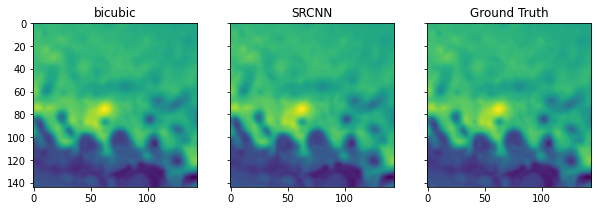

PSNR of Bicubic and Ground Truth image is  46.50548173891396
PSNR of SRCNN and Ground Truth is  45.35717868748498


<Figure size 432x288 with 0 Axes>

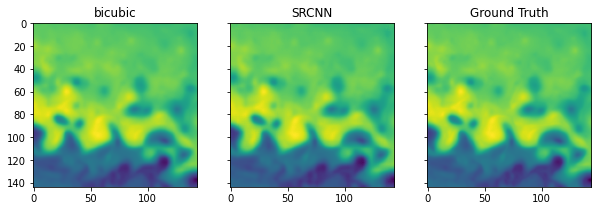

PSNR of Bicubic and Ground Truth image is  43.039905201479414
PSNR of SRCNN and Ground Truth is  36.49179956254676


In [206]:
test_srcnn(srcnn, ssh_lr[366:], ssh[366:])

### Model

In [447]:
filters = 32
upscale_factor = 2

In [448]:
def simple_conv_model( shape=1, filters=filters ):
    ''' extracts SST features '''
    input_img = Input(shape=(None, None, shape))
    x = Conv2D(filters, (3,3), padding='same')(input_img)
    x = LeakyReLU(alpha=0.2)(x)        
    x = Conv2D(filters, (3,3), padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(1, (3,3), padding='same')(x)
    return Model(inputs=input_img, outputs=x)

In [449]:
def shuffle_model( filters=filters ):
    ''' upsamples in feature branch '''
    input_img = Input(shape=(None, None, 1))
    x = Conv2D(filters, (3,3), padding='same')(input_img)
    x = depth_to_space(x, upscale_factor)        
    x = Conv2D(filters, (2,2), padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(1, (3,3), padding='same')(x)
    return Model(inputs=input_img, outputs=x)

In [450]:
def upsample_model( shape=1, filters=filters ):
    ''' upsamples SSH '''
    input_img = Input(shape=(None, None, shape))
    x = Conv2DTranspose(filters, (4,4), strides=(2,2), padding='same')(input_img)
    x = Conv2D(1, (3,3), padding='same')(x)
    return Model(inputs=input_img, outputs=x)

In [461]:
def net():
    simple_conv = simple_conv_model()
    #simple_conv_2 = simple_conv_model(filters)
    shuffle = shuffle_model()
    upsample = upsample_model()
    #upsample_2 = upsample_model(filters)
    
    lr_input = Input(shape=(None,None,1), name="lr_input")
    hr_input = Input(shape=(None,None,1), name="hr_input") 

    # firstPass
    x = simple_conv(hr_input)
    y = upsample(lr_input)
    hr = Add()([y, x])
    # secondPass
    #x = shuffle(x)
    #x = simple_conv(x)
    #y = upsample(hr)
    #hr = Add()([y, x])
    
    return Model(inputs=[lr_input, hr_input], outputs=hr)

### Train the model

In [462]:
loss = keras.losses.MeanSquaredError()

optimizer = keras.optimizers.Adam(learning_rate=0.001)

checkpoint_filepath = "./tmp/checkpoint_dipci"

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="loss",
    mode="min",
    save_best_only=True,
)

callbacks = [early_stopping_callback, model_checkpoint_callback]

In [463]:
dipci = net()
dipci.compile(optimizer=optimizer, loss=loss, metrics=['mse', psnr])
dipci.summary()

In [ ]:
history = dipci.fit(
    x = {"lr_input": ssh_lr[0:366], "hr_input": sst_norm[0:366]},
    y=ssh_norm[0:366], 
    epochs=epochs, 
    callbacks=callbacks, 
    validation_data=valid_ds, 
    verbose=1
)

Epoch 1/100
12/12 [==============================] - 33s 3s/step - loss: 0.1546 - mse: 0.1546 - psnr: 10.3956 - val_loss: 0.0213 - val_mse: 0.0213 - val_psnr: 16.7706
Epoch 2/100
12/12 [==============================] - 32s 3s/step - loss: 0.0204 - mse: 0.0204 - psnr: 17.1085 - val_loss: 0.0120 - val_mse: 0.0120 - val_psnr: 19.2876
Epoch 3/100
12/12 [==============================] - 28s 2s/step - loss: 0.0111 - mse: 0.0111 - psnr: 19.6730 - val_loss: 0.0067 - val_mse: 0.0067 - val_psnr: 21.7739
Epoch 4/100
12/12 [==============================] - 31s 3s/step - loss: 0.0073 - mse: 0.0073 - psnr: 21.3932 - val_loss: 0.0055 - val_mse: 0.0055 - val_psnr: 22.5834
Epoch 5/100
12/12 [==============================] - 29s 2s/step - loss: 0.0056 - mse: 0.0056 - psnr: 22.5854 - val_loss: 0.0045 - val_mse: 0.0045 - val_psnr: 23.4821
Epoch 6/100
12/12 [==============================] - 30s 3s/step - loss: 0.0044 - mse: 0.0044 - psnr: 23.6182 - val_loss: 0.0036 - val_mse: 0.0036 - val_psnr: 24.478

12/12 [==============================] - 30s 3s/step - loss: 1.8787e-04 - mse: 1.8787e-04 - psnr: 37.2555 - val_loss: 1.6920e-04 - val_mse: 1.6920e-04 - val_psnr: 37.7632
Epoch 47/100
12/12 [==============================] - 29s 2s/step - loss: 1.8455e-04 - mse: 1.8455e-04 - psnr: 37.3679 - val_loss: 1.6447e-04 - val_mse: 1.6447e-04 - val_psnr: 37.8801
Epoch 48/100
12/12 [==============================] - 29s 2s/step - loss: 1.8117e-04 - mse: 1.8117e-04 - psnr: 37.4248 - val_loss: 1.6206e-04 - val_mse: 1.6206e-04 - val_psnr: 37.9440
Epoch 49/100
12/12 [==============================] - 31s 3s/step - loss: 1.7843e-04 - mse: 1.7843e-04 - psnr: 37.5011 - val_loss: 1.6121e-04 - val_mse: 1.6121e-04 - val_psnr: 37.9714
Epoch 50/100
12/12 [==============================] - 29s 2s/step - loss: 1.7617e-04 - mse: 1.7617e-04 - psnr: 37.5392 - val_loss: 1.5762e-04 - val_mse: 1.5762e-04 - val_psnr: 38.0617
Epoch 51/100
12/12 [==============================] - 29s 2s/step - loss: 1.7343e-04 - mse: 1

In [ ]:
dipci.load_weights(checkpoint_filepath)

In [ ]:
def test_dipci():
    return